In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import util
import dinuc_shuffle
import pandas as pd
import tensorflow as tf
import kipoiseq
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import pyBigWig
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import logomaker
import seaborn as sns
from scipy.special import softmax

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


In [5]:
# fasta_extractor = util.FastaStringExtractor()

# tf_names = [['GATA', 'GATA6'], ['Nkx2.1', 'NKX2-1']]
# for tf_motif, tf_regulon in tf_names: # repeat for GATA and Nkx
#     _, axes = plt.subplots(1, 2, figsize=[8, 3])

#     regulon = pd.read_csv('/gstore/home/toneyans/weights.csv', index_col='Unnamed: 0').iloc[:, 1:]

#     motifs_of_tf = {'C1':'', 'C3':''}
#     regulon = regulon[regulon['tf']==tf_regulon] # filter GATA or Nkx
#     regulon = regulon[['chr', 'start', 'end', 'tf', 'weight']] # remove extra columns
#     regulon['regulon_id'] = list(range(regulon.shape[0])) # add ID


#     for cluster in motifs_of_tf.keys():
#         model_path = f'doubletRemoved_models/{cluster}_chrombpnet_nobias.h5'
#         model = tf.keras.models.load_model(model_path, custom_objects={"multinomial_nll": util.multinomial_nll})
#         motifs = util.read_bed(f'motifs_in_peaks/{cluster}_Motifs.bed') # get motifs in cluster-specific peaks 
#         motifs['motifs_id'] = list(range(motifs.shape[0])) # add ID
#         motifs[1] = motifs[1].astype(int) # clean up
#         motifs[2] = motifs[2].astype(int)
#         motifs_of_tf[cluster] = motifs[[True if tf_motif in f else False for f in motifs[3]]] # filter GATA or Nkx

#     # add RE coordinates and motif matched weights
#     for cluster in motifs_of_tf.keys():
#         motifs_of_tf[cluster] = util.intersect_beds(regulon, motifs_of_tf[cluster]).merge(regulon, left_on=5, right_on='regulon_id')
#         motifs_of_tf[cluster]['cluster'] = cluster
#     sns.boxplot(data=pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']]), x='cluster', y='weight', ax=axes[0]) # plot C1 vs C3


    
    
    
#     gia_res = {}
#     for cluster in motifs_of_tf.keys():
#         gia_res[cluster] = []

#         L_input = 2114
#         center = L_input // 2
#         motif_length = 20
#         for i, row in tqdm(motifs_of_tf[cluster].iterrows()):
#             chrom, start_motif, end_motif = row[0], row[1], row[2]
#             exp_motif_range = kipoiseq.Interval(chrom, start_motif, end_motif).resize(L_input)

#             wt_seq = fasta_extractor.extract(exp_motif_range)
#             wt_onehot = util.one_hot_encode(wt_seq)
#             # wt_pred = normalize_pred(model, wt_onehot)

#             backgrounds = dinuc_shuffle.dinuc_shuffle(wt_onehot, 10)
#             background_pred = util.normalize_pred(model, backgrounds)
#             test_seqs = backgrounds.copy()
#             test_seqs[:, center-motif_length//2: center+motif_length//2, :] = wt_onehot[center-motif_length//2: center+motif_length//2, :]
#             test_preds = util.normalize_pred(model, test_seqs)
#             gia_js.append(jensenshannon(test_preds[0].numpy().mean(axis=0), background_pred[0].numpy().mean(axis=0))) 
            
            
#         df = pd.DataFrame(gia_js, columns=['GIA JS'])
#         df['cluster'] = cluster
#         gia_res[cluster] = df
#             # gia_count.append( test_preds[1].numpy().mean() - background_pred[1].numpy().mean() )

#     gia_df = pd.concat(gia_res.values())
    
#     sns.boxplot(data=gia_df, x='cluster', y='GIA JS', ax=axes[1])


#     plt.title(tf_regulon)
#     plt.tight_layout()
#     plt.show()

In [81]:
regulon[regulon['regulon_id']==15]

,chr,start,end,tf,weight,C1,C3,regulon_id
260706,chr1,66929975,66930475,NKX2-1,0.737801,0.0,0.112168,15


In [79]:
util.intersect_beds(regulon, motifs_of_tf[cluster])

,0,1,2,3,4,5,6,7
0,chr1,66930019,66930029,NKX2-1,0.737801,0.0,0.112168,15
1,chr1,84387419,84387429,NKX2-1,0.891283,0.0,0.054204,19
2,chr1,95002978,95002988,NKX2-1,0.686898,0.0,0.173335,20
3,chr1,114505275,114505285,NKX2-1,0.780629,0.0,0.123129,22
4,chr1,151804238,151804248,NKX2-1,0.907747,0.0,0.207015,30
...,...,...,...,...,...,...,...,...
64,chr8,28827826,28827836,NKX2-1,0.559129,0.0,0.143073,346
65,chr8,78713439,78713449,NKX2-1,0.997007,0.0,0.240165,350
66,chr8,125180981,125180991,NKX2-1,0.822217,0.0,0.112410,356
67,chr9,33143449,33143459,NKX2-1,0.212401,0.0,0.117472,357


In [3]:
regulon = pd.read_csv('/gstore/home/toneyans/weights.csv')
weights = pd.read_csv('/gstore/home/toneyans/weights_per_cluster.csv')
regulon = regulon.merge(weights, on='Unnamed: 0')[['chr', 'start', 'end', 'tf', 'weight', 'C1', 'C3']]

In [85]:
tf_motif, tf_regulon = ['GATA', 'GATA6']
cluster = 'C1'

In [98]:
motif_regulon = regulon[regulon['tf']==tf_regulon]
motif_regulon['regulon_id'] = list(range(motif_regulon.shape[0]))
motif_regulon = motif_regulon.drop_duplicates(['chr', 'start'])

/local/11753374/ipykernel_26767/347336836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motif_regulon['regulon_id'] = list(range(motif_regulon.shape[0]))


In [99]:
motifs = util.read_bed(f'motifs_in_peaks/{cluster}_Motifs.bed')
motifs['motifs_id'] = list(range(motifs.shape[0]))
motifs[1] = motifs[1].astype(int)
motifs[2] = motifs[2].astype(int)
motifs_of_tf = motifs[[True if tf_motif in f else False for f in motifs[3]]]

In [113]:
motif_regulon_merge = util.intersect_beds(motif_regulon, motifs_of_tf).merge(motif_regulon, left_on=7, right_on='regulon_id')


In [114]:
motif_regulon_merge

,0,1,2,3,4,5,6,7,chr,start,end,tf,weight,C1,C3,regulon_id
0,chr1,27834166,27834186,GATA6,0.849675,0.084431,0.000000,12,chr1,27834018,27834518,GATA6,0.849675,0.084431,0.000000,12
1,chr1,27834169,27834189,GATA6,0.849675,0.084431,0.000000,12,chr1,27834018,27834518,GATA6,0.849675,0.084431,0.000000,12
2,chr1,32761379,32761399,GATA6,0.301167,0.094557,0.000000,16,chr1,32761368,32761868,GATA6,0.301167,0.094557,0.000000,16
3,chr1,32761382,32761402,GATA6,0.301167,0.094557,0.000000,16,chr1,32761368,32761868,GATA6,0.301167,0.094557,0.000000,16
4,chr1,40140384,40140399,GATA6,0.189187,0.043513,0.000000,21,chr1,40140212,40140712,GATA6,0.189187,0.043513,0.000000,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,chr7,51344491,51344506,GATA6,0.955950,0.077354,0.000000,787,chr7,51344306,51344806,GATA6,0.955950,0.077354,0.000000,787
90,chr7,51376617,51376637,GATA6,0.965527,0.003006,0.000000,788,chr7,51376433,51376933,GATA6,0.965527,0.003006,0.000000,788
91,chr8,81314611,81314619,GATA6,0.983715,0.096522,0.000000,831,chr8,81314445,81314945,GATA6,0.983715,0.096522,0.000000,831
92,chr8,124635770,124635790,GATA6,-0.072320,-0.011904,0.154078,848,chr8,124635489,124635989,GATA6,-0.072320,-0.011904,0.154078,848


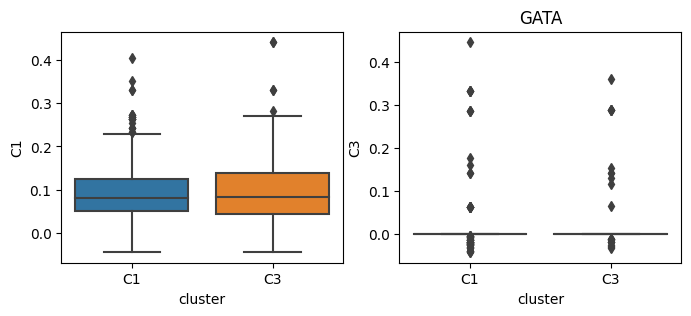

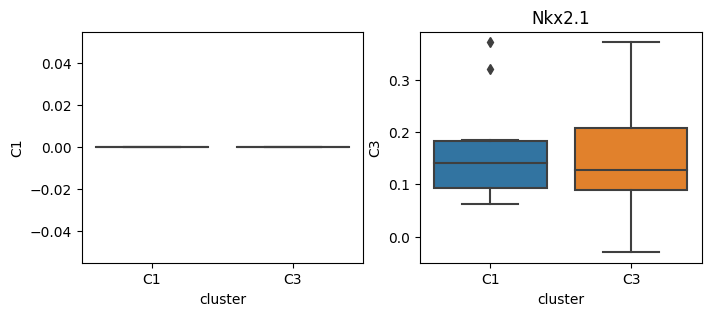

In [4]:
fasta_extractor = util.FastaStringExtractor()
tf_names = [['GATA', 'GATA6'], ['Nkx2.1', 'NKX2-1']]
for tf_motif, tf_regulon in tf_names:
    _, axes = plt.subplots(1, 2, figsize=[8, 3])

    # regulon = pd.read_csv('/gstore/home/toneyans/weights.csv', index_col='Unnamed: 0').iloc[:, 1:]
    regulon = pd.read_csv('/gstore/home/toneyans/weights.csv')
    weights = pd.read_csv('/gstore/home/toneyans/weights_per_cluster.csv')
    regulon = regulon.merge(weights, on='Unnamed: 0')[['chr', 'start', 'end', 'tf', 'weight', 'C1', 'C3']]
    motifs_of_tf = {'C1':'', 'C3':''}

    regulon = regulon[regulon['tf']==tf_regulon]
    regulon = regulon[['chr', 'start', 'end', 'tf', 'weight', 'C1', 'C3']]
    regulon['regulon_id'] = list(range(regulon.shape[0]))


    for cluster in motifs_of_tf.keys():

        motifs = util.read_bed(f'motifs_in_peaks/{cluster}_Motifs.bed')
        motifs['motifs_id'] = list(range(motifs.shape[0]))
        motifs[1] = motifs[1].astype(int)
        motifs[2] = motifs[2].astype(int)
        motifs_of_tf[cluster] = motifs[[True if tf_motif in f else False for f in motifs[3]]]

    # add RE coordinates and motif matched weights
    for cluster in motifs_of_tf.keys():
        motifs_of_tf[cluster] = util.intersect_beds(regulon, motifs_of_tf[cluster]).merge(regulon, left_on=7, right_on='regulon_id')
        motifs_of_tf[cluster]['cluster'] = cluster
    sns.boxplot(data=pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']]), x='cluster', y='C1', ax=axes[0])
    sns.boxplot(data=pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']]), x='cluster', y='C3', ax=axes[1])
    plt.title(tf_motif)

432it [01:06,  6.52it/s]


98it [00:08, 11.68it/s]


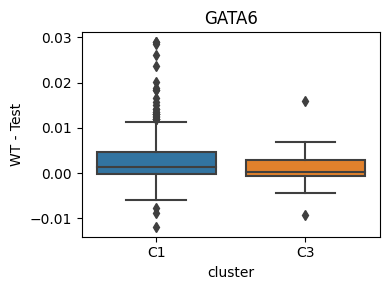

10it [00:00, 11.44it/s]


61it [00:05, 10.42it/s]


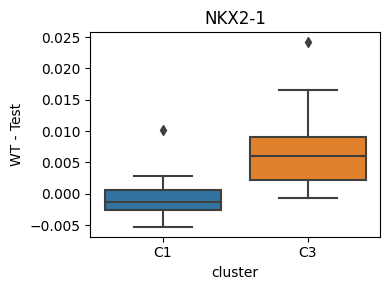

In [5]:
fasta_extractor = util.FastaStringExtractor()
tf_names = [['GATA', 'GATA6'], ['Nkx2.1', 'NKX2-1']]
for tf_motif, tf_regulon in tf_names:
    _, axes = plt.subplots(1, figsize=[4, 3])

    # regulon = pd.read_csv('/gstore/home/toneyans/weights.csv', index_col='Unnamed: 0').iloc[:, 1:]
    regulon = pd.read_csv('/gstore/home/toneyans/weights.csv')
    weights = pd.read_csv('/gstore/home/toneyans/weights_per_cluster.csv')
    regulon = regulon.merge(weights, on='Unnamed: 0')[['chr', 'start', 'end', 'tf', 'weight', 'C1', 'C3']]
    motifs_of_tf = {'C1':'', 'C3':''}

    regulon = regulon[regulon['tf']==tf_regulon]
    regulon = regulon[['chr', 'start', 'end', 'tf', 'weight', 'C1', 'C3']]
    regulon['regulon_id'] = list(range(regulon.shape[0]))


    for cluster in motifs_of_tf.keys():

        motifs = util.read_bed(f'motifs_in_peaks/{cluster}_Motifs.bed')
        motifs['motifs_id'] = list(range(motifs.shape[0]))
        motifs[1] = motifs[1].astype(int)
        motifs[2] = motifs[2].astype(int)
        motifs_of_tf[cluster] = motifs[[True if tf_motif in f else False for f in motifs[3]]]

    # add RE coordinates and motif matched weights
    for cluster in motifs_of_tf.keys():
        motifs_of_tf[cluster] = util.intersect_beds(regulon, motifs_of_tf[cluster]).merge(regulon, left_on=7, right_on='regulon_id')
        motifs_of_tf[cluster]['cluster'] = cluster
    # sns.boxplot(data=pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']]), x='cluster', y='weight', ax=axes[0])
    # # sns.boxplot(data=pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']]), x='cluster', y='weight', ax=axes[1])
    # plt.title(tf_motif)


    
    
    
    gia_res = []
    for cluster in motifs_of_tf.keys():
        # model_path = f'doubletRemoved_models/{cluster}_chrombpnet_nobias.h5'
        model_path = '../gopher-main/epiregulon/basenji_poisson_32/files/best_model.h5'
        if cluster == 'C3':
            model_path = '../gopher-main/epiregulon/basenji_poisson_32_C3/files/best_model.h5'

        model = tf.keras.models.load_model(model_path, 
                                           custom_objects={"multinomial_nll": util.multinomial_nll,
                                                          "GELU": util.GELU}
                                          )
        L_input = 2048
        center = L_input // 2
        
        gia = []
        for i, row in tqdm(motifs_of_tf[cluster].iterrows()):
            chrom, start_motif, end_motif = row[0], row[1], row[2]
            motif_length = end_motif - start_motif
            exp_motif_range = kipoiseq.Interval(chrom, start_motif, end_motif).resize(L_input)

            wt_seq = fasta_extractor.extract(exp_motif_range)
            wt_onehot = util.one_hot_encode(wt_seq)
            # wt_pred_profile, wt_pred_count = util.normalize_pred(model, wt_onehot)
            wt_pred_count = model(wt_onehot[np.newaxis])

            test_seqs = wt_onehot.copy()
            test_seqs[center-motif_length//2: center+motif_length//2, :] = 0.25
            test_pred_count = model(test_seqs[np.newaxis])

            # test_pred_profile, test_pred_count = util.normalize_pred(model, test_seqs)
            gia.append((wt_pred_count.numpy().mean() - test_pred_count.numpy().mean()).flatten())
            
        df = pd.DataFrame(gia, columns=['WT - Test'])
        df['cluster'] = cluster
        gia_res.append(df)
            # gia_count.append( test_preds[1].numpy().mean() - background_pred[1].numpy().mean() )

    gia_df = pd.concat(gia_res)
    
    sns.boxplot(data=gia_df, x='cluster', y='WT - Test', ax=axes)


    plt.title(tf_regulon)
    plt.tight_layout()
    # plt.savefig(f'{tf_motif}.png')
    plt.show()


In [17]:
exp_motif_range = kipoiseq.Interval(chrom, start_motif, end_motif).resize(2114)
wt_seq = fasta_extractor.extract(exp_motif_range)
wt_onehot = util.one_hot_encode(wt_seq)

In [20]:
test_seqs = wt_onehot.copy()
test_seqs[center-motif_length//2: center+motif_length//2, :] = 0.25

In [18]:
model_path = '../CBP_Epiregulon/doubletRemoved_models/C3_chrombpnet_nobias.h5'

model = tf.keras.models.load_model(model_path, 
                               custom_objects={"multinomial_nll": util.multinomial_nll,
                                              "GELU": util.GELU})

In [21]:
bpnet_wt = util.normalize_pred(model, wt_onehot)
bpnet_test = util.normalize_pred(model, test_seqs)

In [41]:
remove_extra = (1000 % 32) // 2
remove_extra 

4

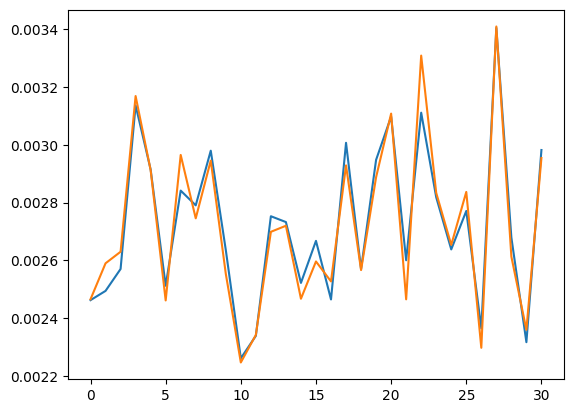

In [42]:
plt.plot((bpnet_wt[0]*bpnet_wt[1]).numpy().flatten()[remove_extra:-remove_extra].reshape(32, -1).mean(axis=0))
plt.plot((bpnet_test[0]*bpnet_test[1]).numpy().flatten()[remove_extra:-remove_extra].reshape(32, -1).mean(axis=0))

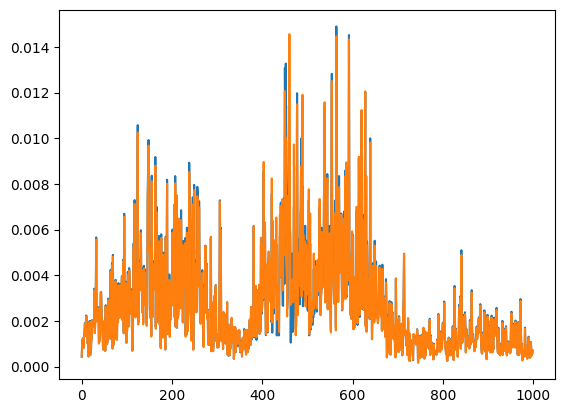

In [37]:
plt.plot((bpnet_wt[0]*bpnet_wt[1]).numpy().flatten().reshape(32, -1).mean(axis=0))
plt.plot((bpnet_test[0]*bpnet_test[1]).numpy().flatten().reshape(32, -1).mean(axis=0))

In [6]:
model_path = '../gopher-main/epiregulon/basenji_poisson_32_C3/files/best_model.h5'

model = tf.keras.models.load_model(model_path, 
                               custom_objects={"multinomial_nll": util.multinomial_nll,
                                              "GELU": util.GELU})

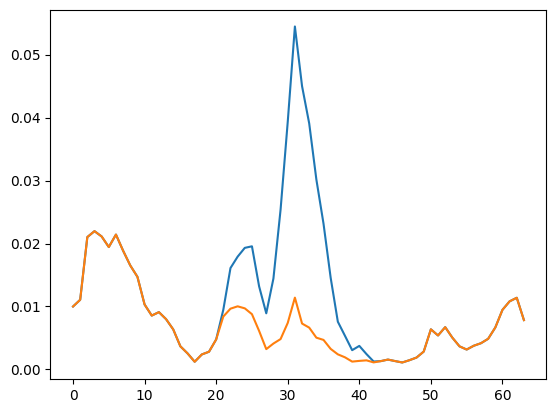

In [11]:
plt.plot(wt_pred_count[0,:,0])
plt.plot(test_pred_count[0,:,0])

GATA
C1:  432
C3:  98
Nkx2.1
C1:  10
C3:  61


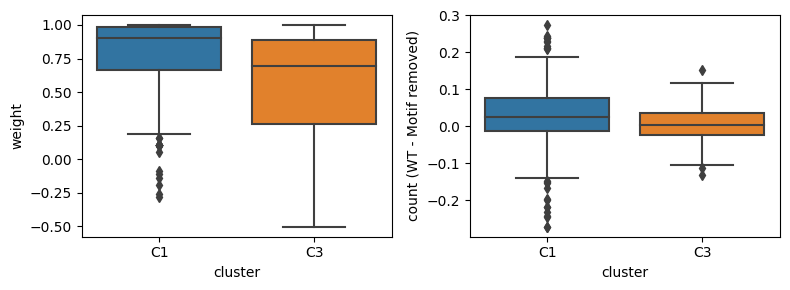

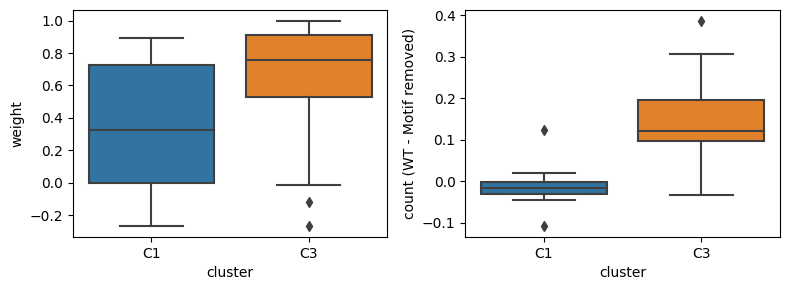

In [34]:
tf_names = [['GATA', 'GATA6'], ['Nkx2.1', 'NKX2-1']]
# tf_names = [['Nkx2.1', 'NKX2-1']]


for tf_motif, tf_regulon in tf_names:
    _, axes = plt.subplots(1, 2, figsize=[8, 3])

    regulon = pd.read_csv('/gstore/home/toneyans/weights.csv', index_col='Unnamed: 0').iloc[:, 1:]

    motifs_of_tf = {'C1':'', 'C3':''}
    regulon = regulon[regulon['tf']==tf_regulon]
    regulon = regulon[['chr', 'start', 'end', 'tf', 'weight']]
    regulon['regulon_id'] = list(range(regulon.shape[0]))


    for cluster in motifs_of_tf.keys():
        motifs = pd.read_csv(f'scores/{cluster}_score.tsv', sep='\t', index_col='Unnamed: 0')
        # motifs = motifs[motifs['5']=='+']
        unwanted_col = 'Unnamed: 0.1'
        if unwanted_col in motifs.columns:
            motifs.drop(columns=unwanted_col, inplace=True)
        motifs['motifs_id'] = list(range(motifs.shape[0]))
        motifs['1'] = motifs['1'].astype(int)
        motifs['2'] = motifs['2'].astype(int)
        motifs_of_tf[cluster] = motifs[[True if tf_motif in f else False for f in motifs['3']]]
    # add RE coordinates and motif matched weights
    for cluster in motifs_of_tf.keys():
        motifs_of_tf[cluster] = util.intersect_beds(regulon, motifs_of_tf[cluster], wb=True).merge(regulon, left_on=5, right_on='regulon_id')
        motifs_of_tf[cluster]['cluster'] = cluster
    print(tf_motif)
    print('C1: ', motifs_of_tf['C1'].shape[0])
    print('C3: ', motifs_of_tf['C3'].shape[0])
    compiled_results = pd.concat([motifs_of_tf['C1'], motifs_of_tf['C3']])
    compiled_results['count (WT - Motif removed)'] = [-i for i in compiled_results[12].values]
    sns.boxplot(data=compiled_results, x='cluster', y='weight', ax=axes[0])
    sns.boxplot(data=compiled_results, x='cluster', y='count (WT - Motif removed)', ax=axes[1])



    
    plt.tight_layout()


In [88]:
motifs[motifs['motifs_id']==15]

,0,1,2,3,4,5,score,jsd_score,rev_score,rev_jsd_score,length,avg_score,motifs_id
Unnamed: 0,,,,,,,,,,,,,
15,chr1,6784563,6784573,AP.1.bZIP_1,.,-,-0.300527,-0.114424,-0.300527,-0.139255,10,-0.030053,15


In [114]:
next(motifs_of_tf['C1'].iterrows())[1]

0                 chr1
1             66930019
2             66930029
3               NKX2-1
4             0.737801
5                   15
chr               chr1
start         66929975
end           66930475
tf              NKX2-1
weight        0.737801
regulon_id          15
cluster             C1
Name: 0, dtype: object

In [19]:
cluster = 'C1'
model_path = f'doubletRemoved_models/{cluster}_chrombpnet_nobias.h5'
model = tf.keras.models.load_model(model_path, custom_objects={"multinomial_nll": util.multinomial_nll})
# row = next(motifs_of_tf['C1'].iterrows())[1]

# chrom, start_motif, end_motif = row[0], row[1], row[2]
chrom, start_motif, end_motif = 'chr1', 66930019, 66930029
motif_length = end_motif - start_motif
exp_motif_range = kipoiseq.Interval(chrom, start_motif, end_motif).resize(L_input)

wt_seq = fasta_extractor.extract(exp_motif_range)
wt_onehot = util.one_hot_encode(wt_seq)
wt_pred_profile, wt_pred_count = util.normalize_pred(model, wt_onehot)
test_seqs = wt_onehot.copy()
test_seqs[center-motif_length//2: center+motif_length//2, :] = 0.

test_pred_profile, test_pred_count = util.normalize_pred(model, test_seqs)

In [20]:
jensenshannon(test_pred_profile.flatten(), wt_pred_profile.flatten())

0.029421986228830875

In [21]:
test_pred_count - wt_pred_count

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01847982]], dtype=float32)>

# try different perturbations 

In [38]:
cluster = 'C1'
model_path = f'doubletRemoved_models/{cluster}_chrombpnet_nobias.h5'
model = tf.keras.models.load_model(model_path, custom_objects={"multinomial_nll": util.multinomial_nll})
L_input = 2114

In [40]:
chrom, start_motif, end_motif = 'chr1', 66930019, 66930029
motif_length = end_motif - start_motif
exp_motif_range = kipoiseq.Interval(chrom, start_motif, end_motif).resize(L_input)

wt_seq = fasta_extractor.extract(exp_motif_range)
wt_onehot = util.one_hot_encode(wt_seq)
wt_pred_profile, wt_pred_count = util.normalize_pred(model, wt_onehot)


tf.Tensor([[4.4167824]], shape=(1, 1), dtype=float32)


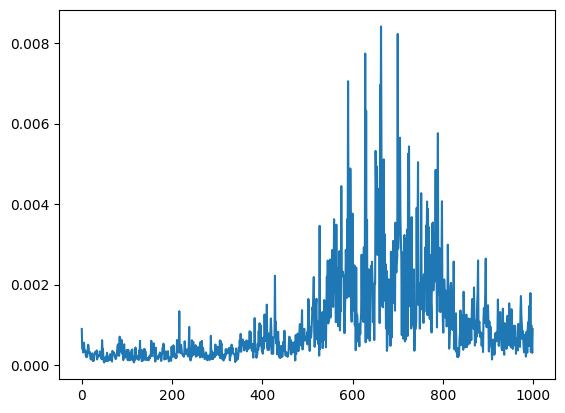

In [45]:
test_seqs = wt_onehot.copy()
test_seqs[center-motif_length//2: center+motif_length//2, :] = 0.25
test_pred_profile, test_pred_count = util.normalize_pred(model, test_seqs)


In [46]:
test_pred_count

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.3743253]], dtype=float32)>

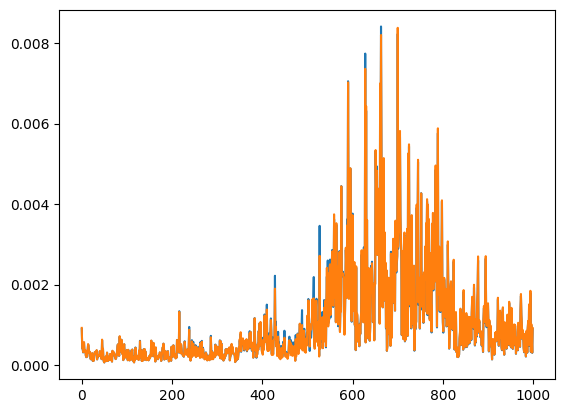

In [47]:
plt.plot(wt_pred_profile[0])
plt.plot(test_pred_profile[0])


,Unnamed: 0,idxATAC,chr,start,end,idxRNA,target,all_x,distance,idxTF,...,qval.C5,qval.C6,weight,all_y,C1,C2,C3,C4,C5,C6
0,1,22,chr1,960317,960817,28,PERM1,0.614227,18210,5,...,NaN,1.000000,0.456128,0.026249,-0.010081,0.0,-0.015928,-0.009941,0.000000,0.100550
1,2,56,chr1,1124416,1124916,40,AL390719.2,0.582570,42439,5,...,1.0,1.000000,-0.013530,0.022966,-0.004540,0.0,0.000000,-0.009151,-0.010259,0.060775
2,3,122,chr1,1375717,1376217,61,CCNL2,0.616679,12724,5,...,1.0,1.000000,0.529504,0.021573,0.113735,0.0,0.086005,-0.004929,-0.020261,0.014502
3,4,631,chr1,7961380,7961880,210,AL034417.4,0.552592,27252,5,...,1.0,1.000000,0.961785,0.026679,0.041079,0.0,0.000000,-0.014439,-0.001670,0.053472
4,5,655,chr1,8061169,8061669,208,TNFRSF9,0.780316,120104,5,...,1.0,1.000000,0.846649,0.053539,0.075454,0.0,0.000000,0.314270,-0.009539,-0.003620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522256,522257,123295,chr9,127937015,127937515,34999,ENG,0.719295,89649,1557,...,1.0,0.485046,0.270786,0.053924,-0.003207,0.0,-0.006428,-0.003715,-0.004552,0.130031
522257,522258,123404,chr9,128829592,128830092,35051,NUP188,0.590378,115605,1557,...,1.0,1.000000,-0.380234,0.050703,0.091960,0.0,-0.042345,0.035899,0.018402,0.065801
522258,522259,123437,chr9,129110677,129111177,35062,AL158151.3,0.636463,62628,1557,...,1.0,1.000000,0.569874,0.074867,-0.008543,0.0,-0.018478,0.000000,0.178983,-0.005499
522259,522260,124017,chr9,136847262,136847762,35226,TMEM141,0.575078,55719,1557,...,1.0,1.000000,-0.564415,0.031136,0.053936,0.0,-0.049087,-0.002659,0.067252,0.040203
